## Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import  dataset

In [3]:
DATASET_PATH = '/media/C/regional_data_1_min'
data_dir = pathlib.Path(DATASET_PATH)

In [4]:
langs = np.array(tf.io.gfile.listdir(str(data_dir)))
langs = [directory for directory in langs if os.path.isdir(os.path.join(DATASET_PATH, directory))]
print('langs:', langs)

langs: ['Assamese', 'Bengali', 'Gujarati', 'Hindi', 'Kannada', 'Kashmiri', 'Khasi and Jaintia', 'Konkani', 'Malayalam', 'Manipuri', 'Marathi', 'Nagamese', 'Nepali', 'Oriya', 'Punjabi', 'Tamil', 'Telegu']


In [5]:
artists = []

for i in langs:
  print(i)
  artists += list(np.array(tf.io.gfile.listdir(str(data_dir) + "/" + i)))
print("artists:", artists)

Assamese
Bengali
Gujarati
Hindi
Kannada
Kashmiri
Khasi and Jaintia
Konkani
Malayalam
Manipuri
Marathi
Nagamese
Nepali
Oriya
Punjabi
Tamil
Telegu
artists: ['Bhupen Hazarika', 'Dipali Barthakur', 'Tarali Sarma', 'Zubeen Garg', 'Arijit Singh', 'Geeta Dutt', 'Manna Dey', 'Shreya Ghoshal', 'Atul Purohit', 'Devang Patel', 'Falguni pathak', 'Geeta Rabari', 'Alka yagnik', 'Kishore Kumar', 'Lata Mangeshkar', 'Sonu Nigam', 'Anuradha Bhat', 'B. K. Sumitra', 'P. B. Sreenivas', 'Rajkumar', 'Raj Begum', 'Rashid Jahangir', 'Shameema Dev Azad', 'Waheed Jeelani', 'George Shadap', 'Rida Gatphoh', 'Soulmate', 'Wanshankupar Suchiang', 'Amit Naik', 'Lorna Cordeiro', 'Remo Fernandes', 'Xavier Gomes', 'K J Yesudas', 'Mohanlal', 'Shweta Mohan', 'Sujatha Mohan', 'Kunjabihari', 'Nongmaithem Pahari', 'Pinky Saikhom', 'Pushparani', 'Hridaynath Mangeshkar', 'Milind Ingle', 'Shridhar Phadke', 'Vaishali Samant', 'David Konyak', 'Mengu Suokhrie', 'Silas Kikon', 'Tetseo Sisters', 'Anju Panta', 'Aruna Lama', 'Narayan G

Extract the audio clips into a list called `filenames`, and shuffle it:

In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/langs[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 680
Number of examples per label: 4
Example file tensor: tf.Tensor(b'/media/C/regional_data_1_min/Nepali/Raju Lama/7.wav', shape=(), dtype=string)


2022-03-26 11:54:42.227412: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-26 11:54:42.714985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 161 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5
2022-03-26 11:54:42.718709: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 161.12M (168951808 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2022-03-26 11:54:42.719322: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 145.01M (152056832 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

In [7]:
train_files = filenames[:544]
val_files = filenames[544: 544 + 64]
test_files = filenames[-64:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 544
Validation set size 64
Test set size 64


## Read the audio files and their labels

In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

- Each WAV file contains time-series data with a set number of samples per second.
- Each sample represents the <a href="https://en.wikipedia.org/wiki/Amplitude" class="external">amplitude</a> of the audio signal at that specific time.
- In a <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16-bit</a> system, like the WAV files in the mini Speech langs dataset, the amplitude values range from -32,768 to 32,767.
- The <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">sample rate</a> for this dataset is 16kHz.

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, where `channels` is `1` for mono or `2` for stereo. This dataset only contains mono recordings. 

In [8]:
test_file = tf.io.read_file(DATASET_PATH+'/Bengali/Arijit Singh/1.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([2880000, 1])

In [9]:
#filenames[497]

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [10]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [11]:
def get_label_lang(file_path):
  print(file_path)
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-3]

def get_label_artist(file_path):
  print(file_path)
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

print(get_label_lang(DATASET_PATH+'/Bengali/Arijit Singh/1.wav'))
print(get_label_artist(DATASET_PATH+'/Bengali/Arijit Singh/1.wav'))

/media/C/regional_data_1_min/Bengali/Arijit Singh/1.wav
tf.Tensor(b'Bengali', shape=(), dtype=string)
/media/C/regional_data_1_min/Bengali/Arijit Singh/1.wav
tf.Tensor(b'Arijit Singh', shape=(), dtype=string)


Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [12]:
def get_waveform_and_label(file_path):
  label_lang = get_label_lang(file_path)
  label_artist = get_label_artist(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label_lang, label_artist

Build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Tensor("args_0:0", shape=(), dtype=string)
Tensor("args_0:0", shape=(), dtype=string)


Let's plot a few audio waveforms:

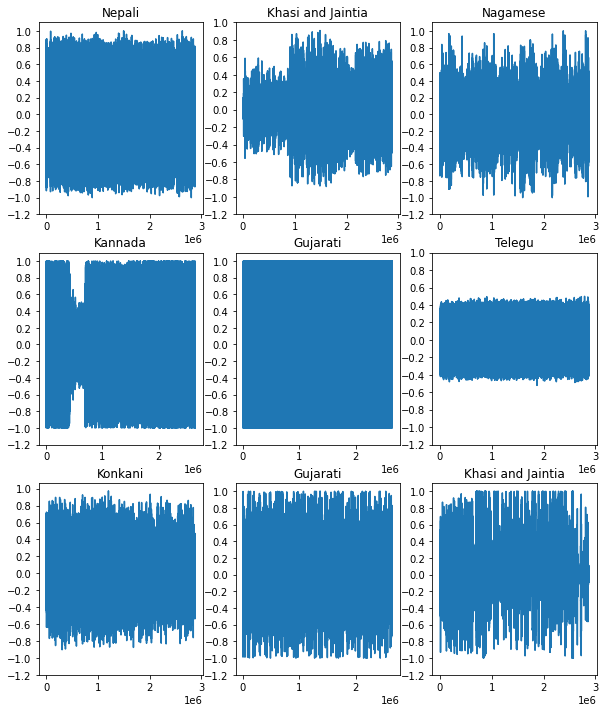

In [15]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label, _) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. 
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [16]:
def get_spectrogram2(waveform):
  # Zero-padding for an audio waveform with less than 260,000 samples.
  input_len = 260000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [260000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [17]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 260,000 samples.
  input_len = 260000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [260000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  #spectrogram = spectrogram[..., tf.newaxis] no new channel for current model
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for waveform, label1, label2 in waveform_ds.take(1):
  label1 = label1.numpy().decode('utf-8')
  label2 = label2.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Labels:', label1, label2)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))

Now, define a function for displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [ ]:
print(tf.argmax(label1 == langs))

In [ ]:
def get_spectrogram_and_label_id(audio, label1, label2):
  spectrogram = get_spectrogram(audio)
  label_id1 = tf.argmax(label1 == langs)
  label_id2 = tf.argmax(label2 == artists)
  return spectrogram, label_id1, label_id2

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [ ]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id, _) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(langs[label_id.numpy()])
  ax.axis('off')

plt.show()

## Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training:

In [ ]:
batch_size = 12
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [ ]:
train_ds = train_ds.prefetch(AUTOTUNE).cache()
val_ds = val_ds.prefetch(AUTOTUNE).cache()

For the model, we refer to: https://arxiv.org/pdf/2006.09815.pdf

The audio is as input after applying fft.

Following which have a stack of Conv1D and max pooling layers which is used to extract the features from the data.

Next we add a Classifier Attention Mechanism. 

The output is the weighted average of the attention layer.

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

Train the model over 10 epochs for demonstration purposes:

Let's plot the training and validation loss curves to check how your model has improved during training:

In [ ]:
#actual model with attention

import keras

for spectrogram, _, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_langs = len(langs)
num_artists = len(artists)

inputlayer = keras.layers.Input(shape=input_shape)

x = keras.layers.Conv1D(16, 4, padding="same", activation = 'relu')(inputlayer)
x = keras.layers.MaxPooling1D(4,2,padding="same")(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.Conv1D(32, 4, padding="same", activation = 'relu')(x)
x = keras.layers.MaxPooling1D(4,2,padding="same")(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.Conv1D(32, 10, padding="same", activation = 'relu')(x)
x = keras.layers.MaxPooling1D(10,5,padding="same")(x)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.Conv1D(128, 10, padding="same", activation = 'relu')(x)
x = keras.layers.MaxPooling1D(10,5,padding="same")(x)

x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
encoder = keras.layers.Dense(12)(x)
x = keras.layers.Dense(12, name="output")(encoder)
attention = keras.layers.Attention()([encoder, x])

label1pred = keras.layers.Dense(num_langs, name = "output1")(x)
label2pred = keras.layers.Dense(num_artists, name = "output2")(x)

model = keras.Model(inputs=inputlayer, outputs=[label1pred, label2pred])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={'output1':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),'output2':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics=['accuracy'],
)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    verbose = 0
)

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
metrics = history.history

plt.plot(history.epoch, metrics['output1_loss'])
plt.plot(history.epoch, metrics['output2_loss'])
plt.legend(['loss1', 'loss2'])
plt.show()

plt.plot(history.epoch, metrics['output1_accuracy'])
plt.plot(history.epoch, metrics['output2_accuracy'])
plt.legend(['accuracy1', 'accuracy2'])
plt.show()

In [ ]:
test_audio = []
test_label1 = []
test_label2 = []

for audio, label1, label2 in test_ds:
  test_audio.append(audio.numpy())
  test_label1.append(label1.numpy())
  test_label2.append(label2.numpy())

test_audio = np.array(test_audio)
test_label1 = np.array(test_label1)
test_label2 = np.array(test_label2)

In [ ]:
y_pred1, y_pred2 = model.predict(test_audio)
y_true1 = test_label1
y_true2 = test_label2

y_pred1 = np.argmax(y_pred1, axis = -1)
y_pred2 = np.argmax(y_pred2, axis = -1)

test_acc1 = sum(y_pred1 == y_true1) / len(y_true1)
print(f'Test set accuracy for label1: {test_acc1:.0%}')

test_acc2 = sum(y_pred2 == y_true2) / len(y_true2)
print(f'Test set accuracy for label2: {test_acc2:.0%}')

### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the langs in the test set:


In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true1, y_pred1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=langs,
            yticklabels=langs,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label1')
plt.show()

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true2, y_pred2)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=artists,
            yticklabels=artists,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label2')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [ ]:
sample_file = data_dir/'Bengali/Arijit Singh/1.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label1, label2 in sample_ds.batch(1):
  pred1, pred2 = model(spectrogram)
  plt.bar(langs, tf.nn.softmax(pred1[0]))
  plt.title(f'Predictions for "{langs[label1[0]]}"')
  plt.show()
  plt.bar(artists, tf.nn.softmax(pred2[0]))
  plt.title(f'Predictions for "{artists[label2[0]]}"')
  plt.show()